# 

In [1]:
%load_ext autoreload
%autoreload 2

In [75]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from problems import IntegerKnapsack

from circuit_lengths import add_lengths_to_df
from regressor import fit_multi

import matplotlib.colors as mco

import quantum_plots as qp
_ = qp.global_setup()

In [31]:
df = pd.read_feather("../../results/qpe_main.feather")

In [32]:
df = df[df.qaoa != "kickback_cost"]

In [33]:
df["method"] = df.qaoa + df["ancilla"].transform(lambda x: "" if np.isnan(x) else "_" + str(int(x)))

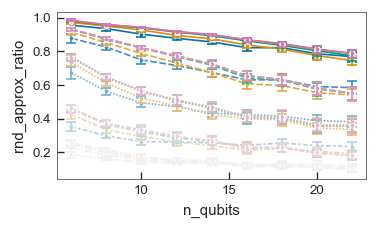

In [118]:
fig, _ = qp.plot_setup()

methods = ["qpe_2", "qpe_4", "qpe_8", "qpe_16", "masked_cost"]

cp = sns.color_palette("colorblind")
styles = ["-", ":", "-.", "--", "-"]

for m, c in zip(methods, cp):
    dfx = df.query("method == @m")

    c = sns.light_palette(c, n_colors=5)
    
    sns.lineplot(
        dfx, 
        x="n_qubits",
        y="rnd_approx_ratio",
        hue="depth",
        style="depth",
        style_order=[16, 8, 4, 2, 1],
        legend=False,
        estimator=np.mean,
        err_style="bars",
        err_kws={"capsize": 3},
        marker="o",
        palette=c,
    )

#.sns.stripplot(df.query("depth == 8"), x="n_qubits", y="rnd_approx_ratio", hue="method", dodge=True, alpha=0.1, legend=False, marker='.', palette="dark", jitter=False)

# plt.yscale("log")
fig.tight_layout()

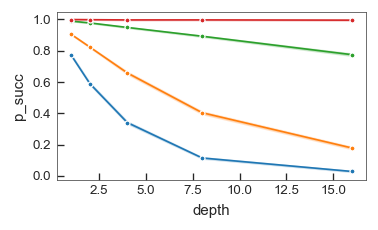

In [130]:
fig, _ = qp.plot_setup()

df["1mp"] = 1 - df.p_succ

sns.lineplot(
    df, 
    x="depth",
    y="p_succ",
    hue="method",
    legend=False,
    # estimator=np.mean,
    # capsize=0.1,
    marker="o",
)
# plt.yscale("log")

fig.tight_layout()

In [131]:
add_lengths_to_df(df, IntegerKnapsack)

In [132]:
df

,depth,energy,approx_ratio,feas_ratio,feas_approx_ratio,p_opt,p_999,p_99,p_9,rnd_approx_ratio,...,initial,beta_scale,gamma_scale,ancilla,shift,method,1mp,clops,two_qubit_ops,weight_ratio
0,1,-0.663487,0.267253,0.481934,0.554544,4.322723e-02,4.322723e-02,0.043227,0.043227,0.144618,...,constant,0.1,0.1,2.0,0.6,qpe_2,0.244061,29.0,32.0,0.269058
1,2,-1.003863,0.404357,0.689212,0.586694,9.519753e-02,9.519753e-02,0.095198,0.095198,0.304668,...,constant,0.1,0.1,2.0,0.6,qpe_2,0.448074,58.0,64.0,0.269058
2,4,-1.828974,0.736713,0.878387,0.838711,5.122185e-01,5.122185e-01,0.512219,0.512219,0.692648,...,constant,0.1,0.1,2.0,0.6,qpe_2,0.697122,116.0,128.0,0.269058
3,8,-2.411648,0.971414,0.984412,0.986796,9.471304e-01,9.471304e-01,0.947130,0.947130,0.966630,...,constant,0.1,0.1,2.0,0.6,qpe_2,0.890084,232.0,256.0,0.269058
4,16,-2.475071,0.996961,0.998298,0.998661,9.944154e-01,9.944154e-01,0.994415,0.994415,0.996453,...,constant,0.1,0.1,2.0,0.6,qpe_2,0.975893,464.0,512.0,0.269058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14395,1,-5.411247,0.516133,0.891175,0.579161,3.549985e-07,3.549985e-07,0.000003,0.000799,0.159167,...,constant,0.1,0.1,NaN,NaN,masked_cost,NaN,105.0,490.0,0.594595
14396,2,-5.834664,0.556519,0.948863,0.586512,1.838587e-07,1.838587e-07,0.000001,0.000555,0.229348,...,constant,0.1,0.1,NaN,NaN,masked_cost,NaN,210.0,980.0,0.594595
14397,4,-6.988934,0.666616,0.942426,0.707340,1.104651e-05,1.104651e-05,0.000059,0.012342,0.420666,...,constant,0.1,0.1,NaN,NaN,masked_cost,NaN,420.0,1960.0,0.594595
14398,8,-8.526331,0.813255,0.978307,0.831288,6.713856e-04,6.713856e-04,0.003483,0.183377,0.675486,...,constant,0.1,0.1,NaN,NaN,masked_cost,NaN,840.0,3920.0,0.594595


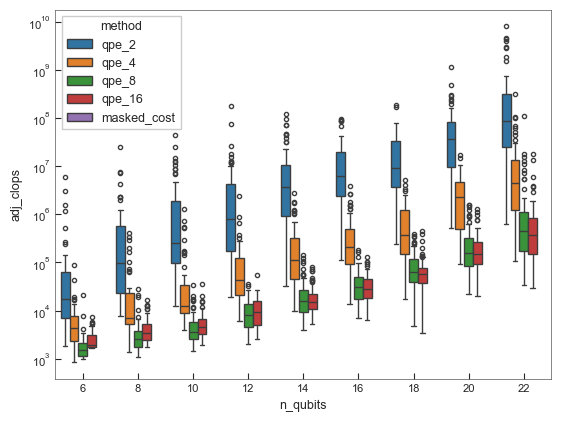

In [147]:
df["adj_clops"] = df.clops / df.p_opt / df.p_succ
sns.boxplot(df.query("depth == 16"), x="n_qubits", y="adj_clops", hue="method", dodge=True)
plt.yscale("log")

In [148]:
df["log_adj_clops"] = np.log(df.adj_clops)

df_fit = fit_multi(df.query("qaoa == 'qpe'"), x="n_qubits", y="log_adj_clops", groupby=["method", "depth"])

df_fit

slope  intercept    rvalue     lower     upper
method depth                                                   
qpe_16 1      0.711250   3.618585  0.964920  0.700133  0.722368
       2      0.741493   3.169142  0.880190  0.719066  0.763921
       4      0.664027   2.987101  0.805024  0.637237  0.690818
       8      0.500186   3.895062  0.814455  0.480614  0.519758
       16     0.311375   5.569086  0.796282  0.298464  0.324287
qpe_2  1      0.738089   2.727572  0.949136  0.724082  0.752097
       2      0.726096   2.952827  0.911410  0.707537  0.744654
       4      0.696741   3.151899  0.861903  0.673877  0.719604
       8      0.560612   5.162688  0.811839  0.538486  0.582738
       16     0.471394   7.927795  0.630288  0.441796  0.500991
qpe_4  1      0.759407   2.569288  0.948054  0.744834  0.773980
       2      0.754070   2.593075  0.882895  0.731556  0.776584
       4      0.702694   2.381097  0.865618  0.679996  0.725392
       8      0.565019   3.653161  0.837274  0.544598  0.585439
       16     0.413757   5.866838  0.720040  0.392606  0.434908
qpe_8  1      0.739152   2.870322  0.967384  0.728026  0.750278
       2      0.761907   2.504441  0.878515  0.738680  0.785135
       4      0.688124   2.320327  0.820520  0.661740  0.714508
       8      0.528990   3.272592  0.833029  0.509575  0.548405
       16     0.351498   4.979578  0.786445  0.336482  0.366514

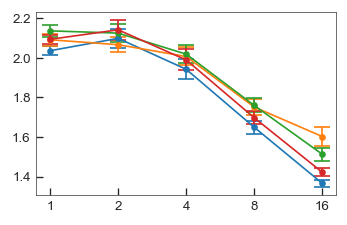

In [149]:
qp.plot_setup()
df_fit["exp_slope"] = np.exp(df_fit.slope)

dfx = df_fit.reset_index()
def plot_method(x):
    bounds = np.abs(np.exp(x[["lower", "upper"]].to_numpy().T) - np.exp(x.slope.to_numpy()[None, :]))
    plt.errorbar(np.arange(len(x.depth)), np.exp(x.slope), yerr=bounds, capsize=5, marker="o")

dfx.groupby("method").apply(plot_method)
_ = plt.xticks(np.arange(len(dfx.depth.drop_duplicates())), dfx.depth.drop_duplicates().astype(int))
# sns.pointplot(df_fit, x="depth", y="slope", hue="method")